In [1]:
"""
This notebook directly sonifies time series data and contains lots 
of modified content from Ben Holtzman's sonification notebooks:
https://github.com/benholtzman/datamovies_y21

It also generates an animation to accompany the audio so you
can see the data in time and frequency space while listening. 
"""

# import and trim the data

import obspy
from obspy import read, Stream
from obspy.core.utcdatetime import UTCDateTime
import numpy as np
import pickle

# to generate/save/load data or not? 
FILENAME = "rr10"
GENERATE_DATA = False
SAVE_DATA = GENERATE_DATA
LOAD_DATA = not SAVE_DATA

# helper function to wrangle mseed files
def trim_Daily_Waveforms(project_Name: str, start_Time, end_Time, channels:
                         list, write_File=False):
    '''loads project data into an Obspy Stream object. By default this will grab the entire day.
    If start_Time and end_Time are specified the Stream object will be trimmed to span that period.
    start_Time and end_Time are UTCDateTime objects

    Example: for all stations in one stream with distance hack, for picking
    start_Time = UTCDateTime("2018-03-13T01:33:00.0Z")
    end_Time =   UTCDateTime("2018-03-13T01:34:00.0Z")
    project_Name = "Rattlesnake Ridge"
    channels = ['DP1', 'EHN']
    trim_Daily_Waveforms(project_Name, start_Time, end_Time, channels, write_File=False)
    
    start_Time = UTCDateTime("2018-04-20T18:10:00.0Z")
    end_Time =   UTCDateTime("2018-04-20T18:14:01.0Z")
    project_Name = "Rattlesnake Ridge"
    channels = ['DP1', 'EHN']
    trim_Daily_Waveforms(project_Name, start_Time, end_Time, 
    channels, write_File=True)
    
    start_Time = UTCDateTime("2018-04-20T11:10:00.0Z")
    end_Time =   UTCDateTime("2018-04-20T11:14:01.0Z")
    project_Name = "Rattlesnake Ridge"
    channels = ['DP1', 'EHN']
    trim_Daily_Waveforms(project_Name, start_Time, end_Time, 
    channels, write_File=True)
    
    Example:
    start_Time = UTCDateTime("2018-03-13T01:33:00.0Z")
    end_Time =   UTCDateTime("2018-03-13T01:33:30.0Z")
    project_Name = "Rattlesnake Ridge"
    channels = ['DP1', 'DP2', 'DPZ', 'EHN', 'EHE', 'EHZ']
    trim_Daily_Waveforms(project_Name, start_Time, end_Time, 
    channels, write_File=True)
    
    '''
    project_Aliases = {"Rattlesnake Ridge": "RR"}

    if project_Name == "Rattlesnake Ridge":
        # build filepath list based on dates, station type, and channels
        node = ['DP1', 'DP2', 'DPZ']  # nodal seismometer channels
        ugap = ['EHN', 'EHE', 'EHZ']
        # order matters for distance hack
        stations_channels = {'1': node, '2': node, '3': node, '5': node,
                             '4': node, '6': node, '7': node, '8': node,
                             '13': node, '9': node, '10': node, '12': node,
                             '15': node, 'UGAP3': ugap, '16': node, '17': node,
                             '18': node, '20': node, '21': node, '22': node,
                             '23': node, '25': node, '26': node, '27': node,
                             'UGAP5': ugap, 'UGAP6': ugap, '28': node,
                             '30': node, '31': node, '32': node, '33': node,
                             '34': node, '35': node, '36': node, '37': node,
                             '38': node, '39': node, '40': node, '41': node,
                             '42': node}

        # to view stations in distance along scarp for picking in Snuffler
        station_distance_hack = {station : index for index, station in
                                 enumerate(stations_channels)}

        filepaths = []
        for station in stations_channels:
            for channel in stations_channels[station]:
                if channel in channels: # is this a channel we specified?
                    # LOCAL LOCATION
                    filepath = f"/Users/tyler/Desktop/MSEED/5A.{station}.." \
                               f"{channel}.{start_Time.year}-" \
                               f"{start_Time.month:02}-{start_Time.day:02}T00.00.00.ms"
                    filepaths.append(filepath)

        obspyStream = Stream()
        for filepath_idx in range(len(filepaths)):
            obspyStream += read(filepaths[filepath_idx]).merge(method=1,
                                                               fill_value=0)
            # station-distance hack for picking, assign number to network
            hack = station_distance_hack[obspyStream[
                filepath_idx].stats.station]
            obspyStream[filepath_idx].stats.network = f'{hack:02}'

    # make sure all traces have the same sampling rate (and number of
    # samples and length) to avoid bugs
    interpolate = False
    for index, trace in enumerate(obspyStream):
        # the sampling rate of the first trace is assumed to be correct
        if trace.stats.sampling_rate != obspyStream[0].stats.sampling_rate:
            print(f"Trace {index} has a different sampling rate. ")
            print(f"Station {trace.stats.station}, Channel "
                  f"{trace.stats.channel}, Start: "
                  f"{trace.stats.starttime}, End: {trace.stats.endtime}")
            # raise the flag
            interpolate = True
    if interpolate:
        print("Interpolating...")
        # interpolate to correct sampling rate and trim to correct time period
        sampling_Rate = obspyStream[0].stats.sampling_rate
        obspyStream = obspyStream.trim(start_Time - sampling_Rate, end_Time
                                       + sampling_Rate)
        npts = int((end_Time-start_Time) * sampling_Rate)
        obspyStream.interpolate(sampling_Rate, method="lanczos",
                                starttime=start_Time, npts=npts, a=30)
        
    else:
        # trim to specified time period
        obspyStream = obspyStream.trim(start_Time, end_Time)

    if write_File:
        # format filename and save Stream as miniseed file
        start_Time_Stamp = str(obspyStream[0].stats.starttime)[
                           11:19].replace(":", ".") # use
        # [:19] for date and time
        end_Time_Stamp = str(obspyStream[0].stats.endtime)[11:19].replace(
            ":", ".")
        # writes to specified path
        obspyStream.write(f"/Users/tyler/Desktop/Programs/sonification/"
                          f"{project_Aliases[project_Name]}_{start_Time_Stamp}_"
                          f"{end_Time_Stamp}.ms", format="MSEED")

    return obspyStream

# get data from files if necessary
if GENERATE_DATA:
    start_Time = UTCDateTime("2018-03-13T22:00:00.0Z")
    end_Time =   UTCDateTime("2018-03-13T23:00:00.0Z")
    project_Name = "Rattlesnake Ridge"
    channels = ['DP1', 'EHN']
    stream = trim_Daily_Waveforms(project_Name, start_Time, end_Time, channels, write_File=False)

    print("\nFinished loading data.")
    print(f"Data length: {len(stream[0].data)}")
    
    if SAVE_DATA:
        # save data to pickle file
        with open(FILENAME+'.pkl', 'wb') as f:
            pickle.dump(stream, f)
        print("Finished pickling.")

# load data if specified
elif LOAD_DATA:
    # load data from pickle file
    with open(FILENAME+'.pkl', 'rb') as f:
        stream = pickle.load(f)

    print("\nFinished loading data.")
    print(f"Data stats: \n{stream[0].stats}\n")
    print(f"Data duration: {(stream[0].stats.endtime - stream[0].stats.starttime)} seconds")
    print(f"Data duration: {(stream[0].stats.endtime - stream[0].stats.starttime) / 60} minutes")
    print(f"Data duration: {(stream[0].stats.endtime - stream[0].stats.starttime) / 60 / 60} hours")
    
# pickle file log 
# FILENAME  |  DURATION  |       START TIME - - - - - - - - END TIME 
# rr0.1.pkl | 6 seconds  | 2018-03-13T06:00:00.0Z - 2018-03-13T06:00:06.0Z
# rr1.pkl   | 1 minute   | 2018-03-13T06:00:00.0Z - 2018-03-13T06:01:00.0Z
# rr10.pkl  | 10 minutes | 2018-03-13T06:00:00.0Z - 2018-03-13T06:10:00.0Z
# rr.pkl    | 6 hours    | 2018-03-13T06:00:00.0Z - 2018-03-13T12:00:00.0Z
# rr60.pkl  | 1 hour     | 2018-03-13T22:00:00.0Z - 2018-03-13T23:00:00.0Z


Finished loading data.
Data stats: 
         network: 00
         station: 1
        location: 
         channel: DP1
       starttime: 2018-03-13T22:00:00.000000Z
         endtime: 2018-03-13T22:59:59.996000Z
   sampling_rate: 250.0
           delta: 0.004
            npts: 900000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 8993, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 36835328})
      processing: ['ObsPy 1.2.2: trim(endtime=UTCDateTime(2018, 3, 13, 23, 4, 10)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2018, 3, 13, 21, 55, 50))', "ObsPy 1.2.2: interpolate(a=30::args=()::method='lanczos'::npts=900000::sampling_rate=250.0::starttime=UTCDateTime(2018, 3, 13, 22, 0)::time_shift=0.0)"]

Data duration: 3599.996 seconds
Data duration: 59.99993333333334 minutes
Data duration: 0.999998888888889 hours


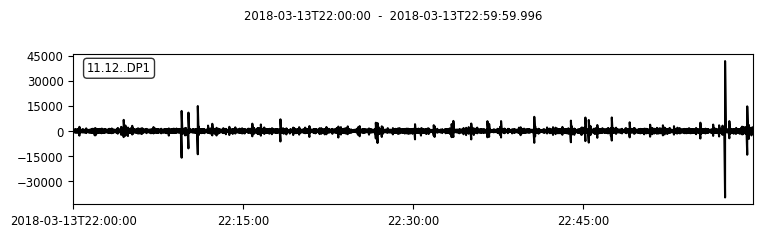

In [2]:
# visualize the time series data 

import matplotlib.pyplot as plt

# picks a single station, trace 11
stream[11].plot()
plt.close() # prevent duplicate figure

Frequency content ranges from 0.0 to 125.0 Hz...
log Frequency content ranges from -3.55630250077 to 2.09690904791 [log10(Hz)]


<ipython-input-3-be7476bdd056>:46: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(f),20*np.log10(np.absolute(S)),'k')


(-3.8389630782010582,
 2.3795696253419063,
 2.8186071263626893,
 140.94253539223936)

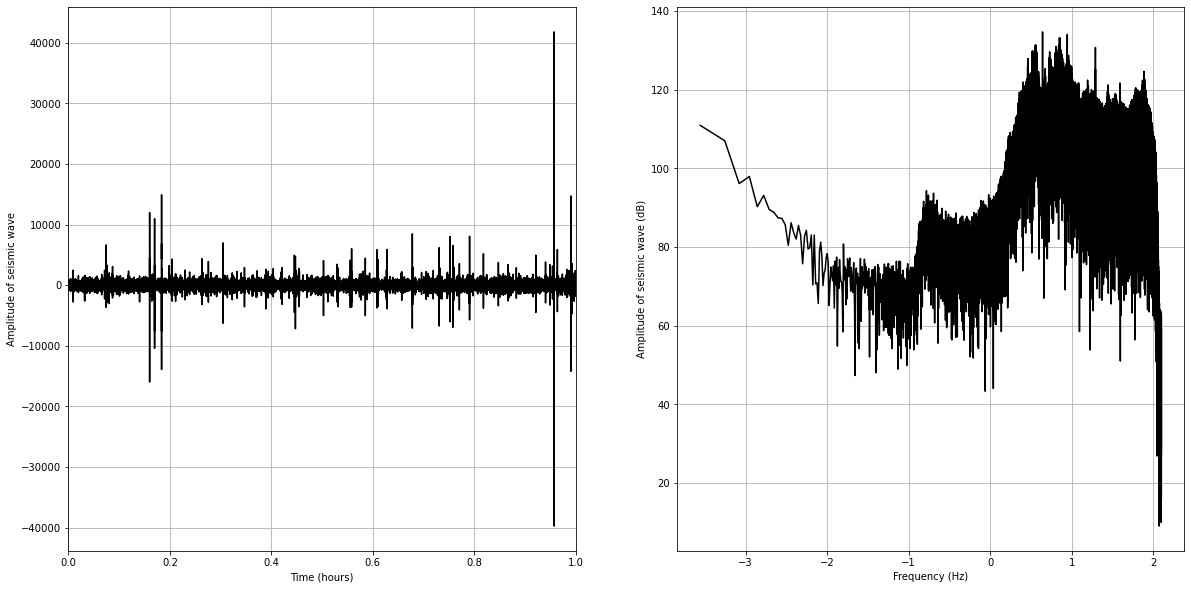

In [3]:
# prepare data for sonification and animation

from scipy import fftpack as spfft # for computing spectra
import scipy.signal as spsig

# define the data and sampling rate
data = stream[11].data # station 12
fs = 250 # sampled at 250 Hz
duration = len(data) / fs

# make time vectors for plotting purposes only
t = np.arange(0, duration, 1./fs) # in seconds
t_hours = np.arange(0,duration/3600,1./fs/3600) # in hours
t_hours = t_hours[:-1]

# 1) force the signal's mean value to be zero (to protect your loudspeakers)
data = data - np.mean(data)

# 2) limit the signal's amplitude = avoid too large peaks (how to re-kill your loudspeakers)
data_n = data/np.amax(np.absolute(data))

# compute the spectrum
# Nfft is the number of frequencies to calculate in a discrete signal (i.e. in a computer)
Nfft = len(data_n)
f = np.arange(0,fs/2,fs/Nfft) # to get the actual frequency values
S = spfft.fft(data,Nfft) 
S = S[:int(Nfft/2)] # remove any information from frequencies higher than Nyquist (half the number of points)

print('Frequency content ranges from ' + str(f[0]) + ' to ' + str(round(f[-1],3)) + ' Hz...')
print('log Frequency content ranges from ' + str(np.log10(f[1])) + ' to ' + str(np.log10(f[-1])) + ' [log10(Hz)]')

# plot waveform
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(t_hours,data,'k') 
plt.xlabel('Time (hours)')
plt.ylabel('Amplitude of seismic wave')
plt.grid()
plt.xlim([0,duration/3600])

# plot spectrum
plt.subplot(1,2,2)
#plt.plot(f,20*np.log10(np.absolute(S)),'k') 
plt.plot(np.log10(f),20*np.log10(np.absolute(S)),'k') 
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude of seismic wave (dB)')
plt.grid()
plt.axis()

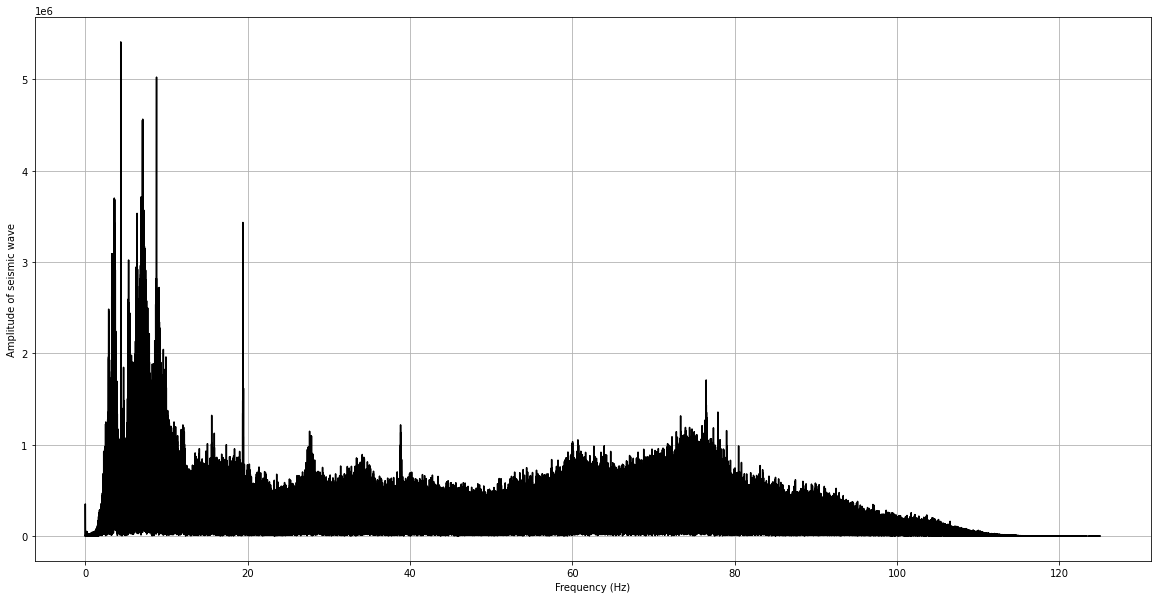

In [4]:
plt.figure(figsize=(20,10))
plt.plot(f,np.absolute(S),'k') 
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude of seismic wave')
plt.grid()
#plt.xlim([0.0002, 0.002])

window duration in seconds: 3.6
window length in samples: 900
1800
(901, 1999)
(901,)
(1999,)


Text(0, 0.5, 'dB')

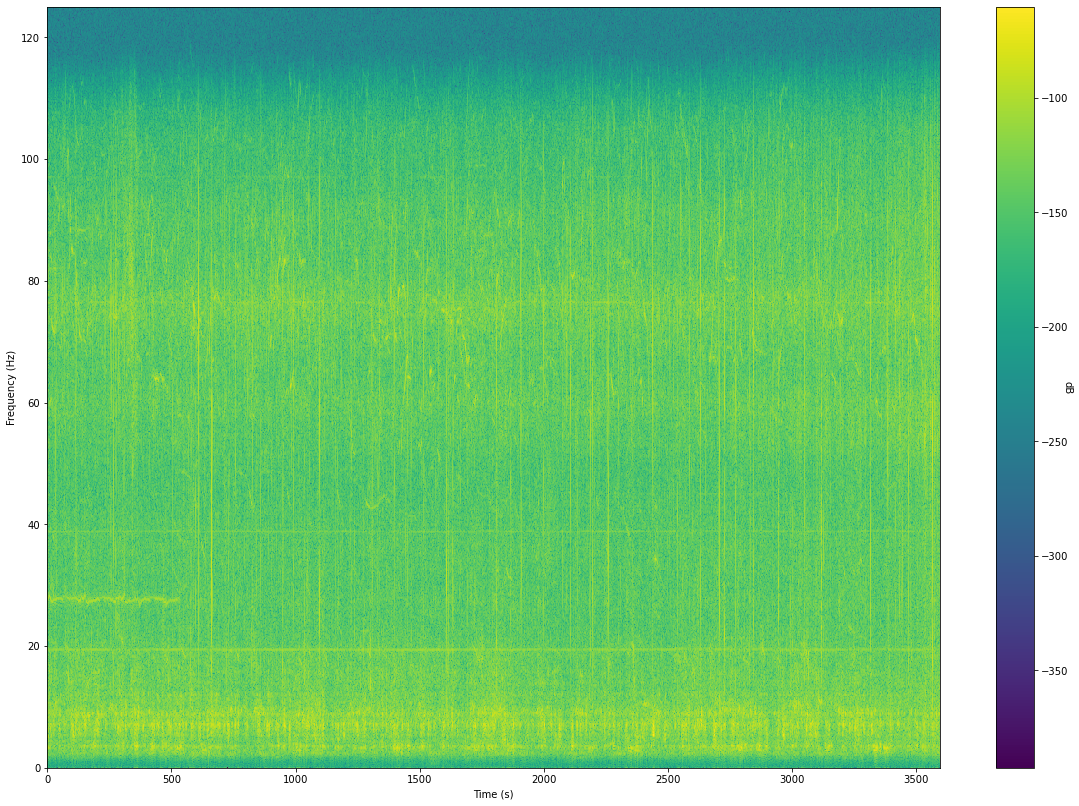

In [5]:
# generate a spectrogram
# first compute the short time fourier transform STFT

duration = len(data)/fs
numwindows = 1000
WindowDur = duration/numwindows
WindowLength = int(WindowDur*fs) # [s] The length of each frame (should be expressed in samples)
NfftSTFT = WindowLength*2 # you want the Nyquist frequency to be the window length (in number of samples, not seconds)

print('window duration in seconds: ' +str(WindowDur))
print('window length in samples: ' +str(WindowLength))
print(NfftSTFT)

Overlap = int(WindowLength/2) # The overlapping between successive frames (should be expressed in samples)

[fSTFT, tSTFT, STFT] = spsig.spectrogram(data_n, fs, nperseg=WindowLength, noverlap=Overlap, nfft=NfftSTFT) 
print(STFT.shape)
print(fSTFT.shape)
print(tSTFT.shape)

# plot the spectrogram
plt.figure(figsize=(20,14))
plt.pcolormesh(tSTFT,fSTFT,20*np.log10(np.absolute(STFT))) # dB = 20*log() is a convention
#plt.ylim([0,fs/8])
plt.xlim([0,duration-WindowLength/fs])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
cbar = plt.colorbar()
cbar.ax.set_ylabel('dB', rotation=270)

Using matplotlib backend: MacOSX
num frames = 18000
movie_dur = 600
frame_interval = 0.03333333333333333
frames per sec = 30.0


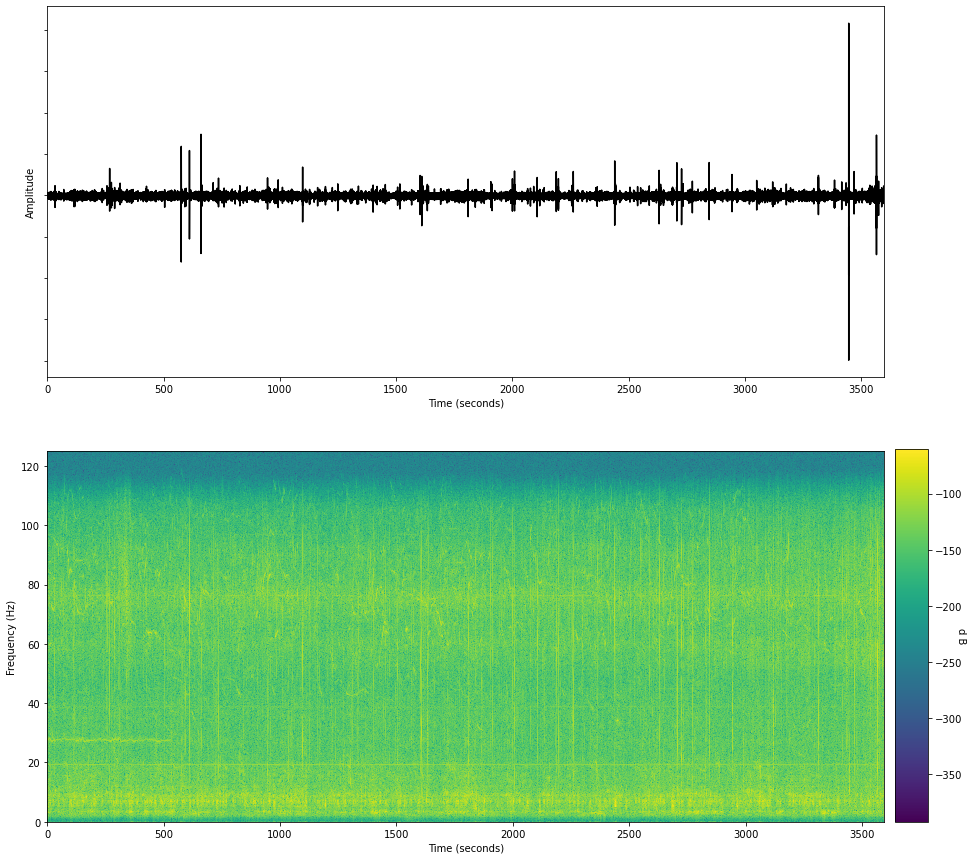

In [6]:
# animate time traversal 

# Purpose: generate animation of time traversal on a single data channel on a single station, to be 
#          combined with amplitude mapped to sound in later cells 

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib auto 
%matplotlib inline

# class that lets the "patches" object not stretch the dots
class GraphDist() :
    def __init__(self, size, ax, x=True) :
        self.size = size
        self.ax = ax
        self.x = x

    @property
    def dist_real(self) :
        x0, y0 = self.ax.transAxes.transform((0, 0)) # lower left in pixels
        x1, y1 = self.ax.transAxes.transform((1, 1)) # upper right in pixes
        value = x1 - x0 if self.x else y1 - y0
        return value

    @property
    def dist_abs(self) :
        bounds = self.ax.get_xlim() if self.x else self.ax.get_ylim()
        return bounds[0] - bounds[1]

    @property
    def value(self) :
        return (self.size / self.dist_real) * self.dist_abs

    def __mul__(self, obj) :
        return self.value * obj

# first copy and decimate stream for animation, else takes a long time to process
ani_Stream = stream.copy()
# ani_Stream.decimate(10, strict_length=False, no_filter=True)
    
# define data to work with
time = ani_Stream[11].times() # trace 11, station 12
amplitude = ani_Stream[11].data

# initialize the figure and plot the data
fig = plt.figure(figsize=(15,15))

# make the first plot
axes1 = plt.subplot(2,1,1) 
axes1.plot(time, amplitude,'k-')
axes1.set_ylabel('Amplitude')
axes1.set_yticklabels([])
axes1.set_xlabel('Time (seconds)')
axes1.set_xlim([time[0], time[-1]])

# make the second plot
axes2 = plt.subplot(2,1,2) 
a2 = axes2.pcolormesh(tSTFT,fSTFT,20*np.log10(np.absolute(STFT))) # dB = 20*log() is a convention
#axes.ylim([0,fs/8])
axes2.set_xlim([0,duration-WindowLength/fs])
axes2.set_xlabel('Time (seconds)')
axes2.set_ylabel('Frequency (Hz)')
# adjust plots and make room for colorbar
#plt.subplots_adjust(right=0.94)
#cax = plt.axes([0.95, 0.125, 0.03, 0.345])
plt.subplots_adjust(right=0.90)
cax = plt.axes([0.91, 0.125, 0.03, 0.345])
cbar = fig.colorbar(a2, cax=cax) # orientation="horizontal"
cbar.ax.set_ylabel('d B', rotation=270)

# set size of dot
rad_pix = 30

# scale the ellipse axes to the data so they are round dots
dot1_width = GraphDist(rad_pix, axes1, True)
dot1_height = GraphDist(rad_pix, axes1, False)

# set rectangle sizes to make a line traversing the spectrogram
line1_width = 1
line1_height = 2000 # 400 for rr10, 

# define the patch objects
patch1 = patches.Ellipse((time[0], amplitude[0]), dot1_width, dot1_height, fc='red')
patch2 = patches.Rectangle((time[0], 0), line1_width, line1_height, fc='red') # amplitude[0]

# initialize what will move in the animation
def init():
    patch1.center = (time[0], amplitude[0])
    axes1.add_patch(patch1)
    patch2.set_x(time[0])
    axes2.add_patch(patch2)
    
    return patch1, patch2,

# define what will move in the animation
def animate(i):
    i = int(i * animate_Scale_Factor)
    x , y = time[i], amplitude[i]
    patch1.center = (x, y)
    axes1.add_patch(patch1)
    patch2.set_x(x)
    axes2.add_patch(patch2)
    
    return patch1, patch2,

# for 30 fps from 250 Hz data
# FIXME: duration doesn't match output duration. beware!
movie_dur = 600 # in seconds, 300 yeilds 14 seconds, 600 yeilds 30
fps = 30
n_frames = movie_dur * fps #*30
# number of movie frames based on specified fps
time_ind_vec = np.arange(0, n_frames-1)
animate_Scale_Factor = len(time) / n_frames

print('num frames = ' + str(n_frames))
print('movie_dur = ' + str(movie_dur))

frame_interval_sec = interv = movie_dur/n_frames
print('frame_interval = ' + str(frame_interval_sec))
fps_ideal = 1./frame_interval_sec
print('frames per sec = ' + str(fps_ideal))

# plt.show()
# plt.savefig(FILENAME+'.pdf', dpi=600)
plt.ioff()

In [ ]:
# play movie inline
ani = animation.FuncAnimation(fig, animate, time_ind_vec, interval=interv, init_func=init) # frames=n_frames, blit=True, interval=interv*50
HTML(ani.to_html5_video())

In [ ]:
# save the animation
moviename = FILENAME+'.avi'
ani.save(moviename)

In [7]:
print(n_frames)
# number of movie frames based on specified fps
print(time_ind_vec)
print(frame_interval_sec)
print(fps_ideal)

18000
[    0     1     2 ..., 17996 17997 17998]
0.03333333333333333
30.0


In [8]:
# sonify

import IPython.display as ipd
import resampy

OutFileName = FILENAME + '.wav'

# For the free oscillations, we had a specific frequency that we wanted to shift to another one
# Here we can define a target duration instead
OriginalDuration = duration
TargetDuration = 30.0
print('The data is ' + str(int(OriginalDuration)) + '-s long')
print('Let\'s make a ' + str(TargetDuration) + '-second long sound!')

SpeedFactor = OriginalDuration/TargetDuration
print('This corresponds to a speed factor of: ' + str(int(SpeedFactor)))

# (here we are speeding up the playback because the original content is infrasonic / 
# There are cases where we want to do the opposite, e.g. solar magnetic waves, acoustic emissions during rock microcracking...)
# compute the corresponding shift in frequency
# show the result with subplots original data VS. sonified data 
#      (time series / spectrum / spectrogram = no change except in the time scale)

# So, set the new sampling rate, and then resample to a standard sampling rate
# set the new sampling rate, and then resample to a standard sampling rate
sr_sound = int(fs*SpeedFactor)
# fs_sound = int(fs*SpeedFactor)
sr_resample = 44100 
# resample at 44.100 kHz
data_rs = resampy.resample(data_n, sr_sound, sr_resample)

import soundfile as sf
#sf.write(FILENAME+".wav", data_n, 4*fs_sound)
sf.write(OutFileName, data_rs, sr_resample)

#librosa.output.write_wav(DirOut + OutFileName, data_n, 4*fs_sound, norm=False)

# Some software have troubles with exotic sampling rates (VLC and audacity don't have), so it might be necessary 
# to resample your sound.
#dataOrig, srOrig = librosa.core.load(OutFileName, sr=sr_sound)
#data_rs = resampy.resample(dataOrig, srOrig, sr_resample)
#librosa.output.write_wav(DirOut + OutFileName, data_rs, sr_resample, norm=False)
#sf.write(OutFileName, data_rs, sr_resample)

#ipd.Audio(data_n, rate=2*fs_sound) 
#ipd.Audio(data_rs, rate=fs_sound/2) 

ipd.Audio(data_rs, rate=sr_resample) 

The data is 3600-s long
Let's make a 30.0-second long sound!
This corresponds to a speed factor of: 120


In [9]:
# add the sound file to the movie file 
import subprocess as sp
run_ffmpeg_movie_cmd = 'ffmpeg -i ' + FILENAME+'.wav' + ' -i ' + FILENAME+'.avi' + ' -qscale 0' + ' ' + FILENAME+'_fin.avi'
make_movie = sp.Popen(run_ffmpeg_movie_cmd, shell=True) 
make_movie.wait()

1